# Telecom


We have a data about customers churn, tariffs and contracts. A goal of the project is to predict customers churn.

### Service Description

The operator provides two main types of services:

1. Fixed-line telephone communication. It is possible to connect a telephone device to multiple lines simultaneously.
2. Internet. The connection can be of two types: through a telephone line (DSL - Digital Subscriber Line) or fiber optic cable (Fiber optic).

The following services are also available:

- Internet security: antivirus (DeviceProtection) and blocking of unsafe websites (OnlineSecurity);
- Dedicated technical support line (TechSupport);
- Cloud storage for data backup (OnlineBackup);
- Streaming TV (StreamingTV) and movie catalog (StreamingMovies).

Customers can pay for services on a monthly basis or enter into a contract for 1-2 years. Various payment methods are available, as well as the option to receive an electronic receipt.

### Data Description

The data consists of files obtained from various sources:

- `contract_new.csv` - contract information;
- `personal_new.csv` - customer's personal data;
- `internet_new.csv` - information about internet services;
- `phone_new.csv` - information about phone services.

In all files, the `customerID` column contains the customer code.

The contract information is up-to-date as of February 1, 2020.

### Project Objective

Create a machine learning model that can predict customer churn with high accuracy. This will allow the company to proactively offer promo codes and special conditions to retain customers.

The target metric is ROC-AUC >= 0.85 and accuracy.

# Exploratory Data Analysis

Let's start by importing packages and loading the dataset.

In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from phik.report import plot_correlation_matrix
import warnings

warnings.filterwarnings('ignore')

In [36]:
RANDOM_STATE = 220523

In [37]:
BASE_DIR = os.getcwd()

try:
    df_contract = pd.read_csv(f"{BASE_DIR}/datasets/contract_new.csv")
    df_internet = pd.read_csv(f"{BASE_DIR}/datasets/internet_new.csv")
    df_personal = pd.read_csv(f"{BASE_DIR}/datasets/personal_new.csv")
    df_phone = pd.read_csv(f"{BASE_DIR}/datasets/phone_new.csv")
except FileNotFoundError:
    df_contract = pd.read_csv("/datasets/contract_new.csv")
    df_internet = pd.read_csv("/datasets/internet_new.csv")
    df_personal = pd.read_csv("/datasets/personal_new.csv")
    df_phone = pd.read_csv("/datasets/phone_new.csv")

Let's examine the dataframes.

### df_contract

In [38]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [39]:
df_contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [40]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


The dataframe contains the following features:
- `customerID` - user identifier (the key used to join the tables);
- `BeginDate` - date of contract start;
- `EndDate` - date of contract termination (if the subscriber has canceled the services, it is the target feature);
- `Type` - contract type based on the payment period (monthly payment, annual payment, payment every two years);
- `PaperlessBilling` - type of receiving payment receipts;
- `PaymentMethod` - payment method;
- `MonthlyCharges` - cost of services per month;
- `TotalCharges` - total cost of services for the entire period.

### df_personal

In [41]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


The dataframe contains the following features:
- `customerID` - user identifier (the key used to join the tables);
- `gender` - subscriber's gender;
- `seniorCitizen` - whether the subscriber is a senior citizen;
- `Partner` - presence/absence of a partner;
- `Dependents` - presence/absence of dependents.

In [42]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


### df_internet

In [43]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [44]:
df_internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

In [45]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


The dataframe contains the following features:
- `customerID` - user identifier (the key used to join the tables);
- `InternetService` - type of connection (DSL, fiber optic);
- `OnlineSecurity` - blocking of unsafe websites;
- `OnlineBackup` - cloud storage for data backup;
- `DeviceProtection` - antivirus;
- `TechSupport` - dedicated technical support line;
- `StreamingTV`- streaming TV;
- `StreamingMovies`- movie catalog.

Except for `customer_ID`, all features in the dataframe are binary and can be converted to boolean data type.

### df_phone

In [46]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [47]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


The dataframe contains the following features:
- `customerID` - user identifier (the key used to join the tables);
- `MultipleLines` - number of home phone lines connected to the subscriber - one/more than one.

Let's check for duplicates.

In [48]:
print(df_contract.duplicated().sum())
print(df_personal.duplicated().sum())
print(df_internet.duplicated().sum())
print(df_phone.duplicated().sum())

0
0
0
0


There are no duplicates in the data.

Let's check if the number of `customerID` matches.

In [49]:
print(len(df_contract['customerID'].unique()))
print(len(df_personal['customerID'].unique()))
print(len(df_internet['customerID'].unique()))
print(len(df_phone['customerID'].unique()))

7043
7043
5517
6361


The number of `customerID` is the same in the `df_contract` and `df_personal` dataframes. The first one contains contract information, while the second one contains customer's personal data. The other two datasets, namely `internet_new.csv` (information about internet services) and `phone_new.csv` (information about phone services), have fewer records. Since not all users use all the provided services, it is logical that there are fewer objects in these dataframes.

There are no missing values or duplicates in the data.
The headers are not standardized.
The data types often do not correspond to the nature of the stored data.
All dataframes need to be merged into one based on the `customerID` key.
From the `df_contract` dataframe, the target feature needs to be extracted. If the `EndDate` column contains a date, it means the subscriber has left the company. In the same table, there is a `BeginDate` column from which we can obtain the number of days the subscriber was a customer. Both original features can be removed.

Almost all features are binary categorical, so it is advisable to process them using an OHE (One-Hot Encoding) encoder.

## Data preprocessing

Merge the dataframes into one

In [50]:
df = df_contract.merge(df_personal, on = 'customerID')
df = df.merge(df_internet, on = 'customerID', how = 'left')
df = df.merge(df_phone, on = 'customerID', how = 'left')

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Remove `customerID` as it is no longer needed, it was only used for merging the tables.

In [52]:
df = df.drop('customerID', axis=1)

In [53]:
df.columns

Index(['BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines'],
      dtype='object')

Convert headers to `camelCase`

In [54]:
df.columns = df.columns.str[0].str.lower() + df.columns.str[1:]

In [55]:
df.columns

Index(['beginDate', 'endDate', 'type', 'paperlessBilling', 'paymentMethod',
       'monthlyCharges', 'totalCharges', 'gender', 'seniorCitizen', 'partner',
       'dependents', 'internetService', 'onlineSecurity', 'onlineBackup',
       'deviceProtection', 'techSupport', 'streamingTV', 'streamingMovies',
       'multipleLines'],
      dtype='object')

Convert data types.

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   beginDate         7043 non-null   object 
 1   endDate           7043 non-null   object 
 2   type              7043 non-null   object 
 3   paperlessBilling  7043 non-null   object 
 4   paymentMethod     7043 non-null   object 
 5   monthlyCharges    7043 non-null   float64
 6   totalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   seniorCitizen     7043 non-null   int64  
 9   partner           7043 non-null   object 
 10  dependents        7043 non-null   object 
 11  internetService   5517 non-null   object 
 12  onlineSecurity    5517 non-null   object 
 13  onlineBackup      5517 non-null   object 
 14  deviceProtection  5517 non-null   object 
 15  techSupport       5517 non-null   object 
 16  streamingTV       5517 non-null   object 


Since all categorical features will be transformed using OHE, we need to convert `totalCharges` to `float`, as well as `beginDate` and `endDate` to `datetime`.

In [57]:
df['totalCharges'] = df['totalCharges'].replace(" ", 0).astype('float32')

Extract the target feature from `beginDate`, if the object contains the value `No`, it means that the contract is still active and the target feature value is `0`, otherwise `1`

In [58]:
df['exited'] = np.where(df['endDate'] == 'No', 0, 1)

The `endDate` column contains the value `No` if the contract is still active. Since the information is up to date as of February 1, 2020, we will replace `No` in `endDate` with this date.

In [59]:
df['endDate'] = df['endDate'].replace('No', '2020-02-01 00:00:00')
df['endDate'] = pd.to_datetime(df['endDate'], format='%Y-%m-%d')
df['beginDate'] = pd.to_datetime(df['beginDate'], format='%Y-%m-%d')

Create a feature with the duration of the contract in months.

In [60]:
df['contractDurationMonths'] = (df['endDate'] - df['beginDate'])/np.timedelta64(1, 'M')

Remove unnecessary features `beginDate` and `endDate`

In [61]:
df = df.drop(['beginDate', 'endDate'], axis=1)

We can optimize numeric data types.

In [62]:
float_cols = df.select_dtypes('float').columns
int_cols = df.select_dtypes('integer').columns

df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')

Before merging, the number of objects in the tables did not match, so there should be missing values in the final dataframe.

In [63]:
df.isna().sum()

type                         0
paperlessBilling             0
paymentMethod                0
monthlyCharges               0
totalCharges                 0
gender                       0
seniorCitizen                0
partner                      0
dependents                   0
internetService           1526
onlineSecurity            1526
onlineBackup              1526
deviceProtection          1526
techSupport               1526
streamingTV               1526
streamingMovies           1526
multipleLines              682
exited                       0
contractDurationMonths       0
dtype: int64

For encoding categorical features, we can use OHE and fill in missing values. However, since we plan to use cross-validation, we will do this directly in the model training pipeline. Now let's proceed to exploratory data analysis.

# Plan

1. Conduct exploratory data analysis:
- analyze each feature in terms of the target feature classes.
2. Complete data preprocessing:
- generate additional features;
- split the dataset into features and target.
3. Train models:
- create a pipeline based on gridsearchcv. Before training the models, use one-hot encoding and feature scaling for linear models. Also, balance the classes within the pipeline.
- train linear regression, random forest, and XGBoost models using ROC-AUC as the loss function;
- select the best model, plot the ROC curve, and determine the optimal threshold;
- evaluate the best model on the test dataset and compare it with a constant model.
4. Draw conclusions based on the work conducted.

### Data Analysis

Check the imbalance of the target variable

In [64]:
df['exited'].value_counts()

0    5942
1    1101
Name: exited, dtype: int64

The target variable is imbalanced, so it is necessary to consider this during model training and add class balancing to the pipeline.

### Analysis of Numeric Features

Let's try to understand how the numeric features (monthly and total charges) affect the target feature.

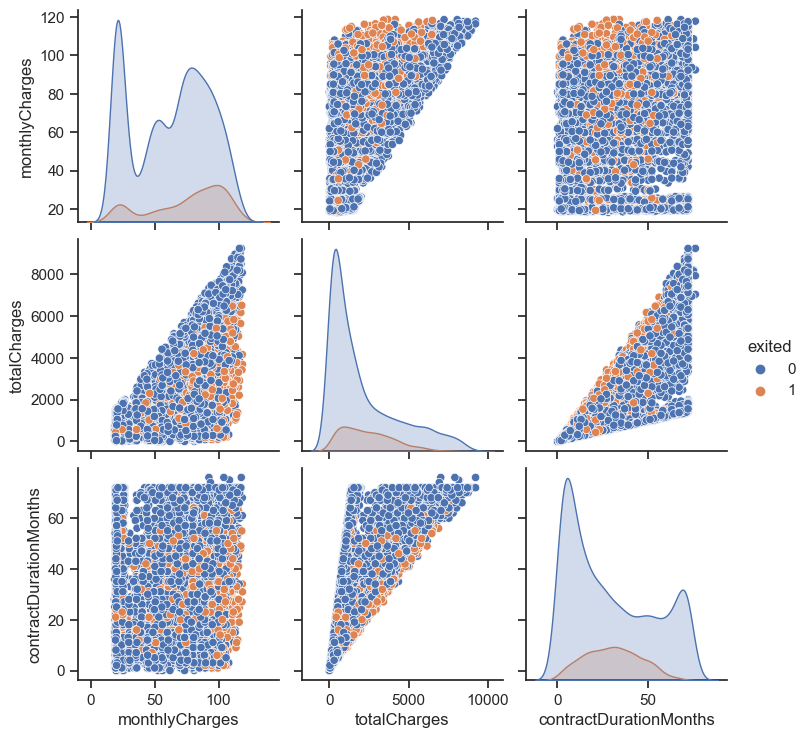

In [65]:
sns.set_theme(style="ticks")
sns.pairplot(df[['monthlyCharges', 
                 'totalCharges', 
                 'contractDurationMonths', 
                 'exited']], 
                 hue='exited')
plt.show()

The "cluster" of churned customers can be described by the following statements:  
1. The monthly charges of churned customers were higher than those who stayed. Customers with low monthly charges for services are less likely to churn;  
2. Customers mostly churned around the 30th month.  

Let's take a closer look at the last statement.

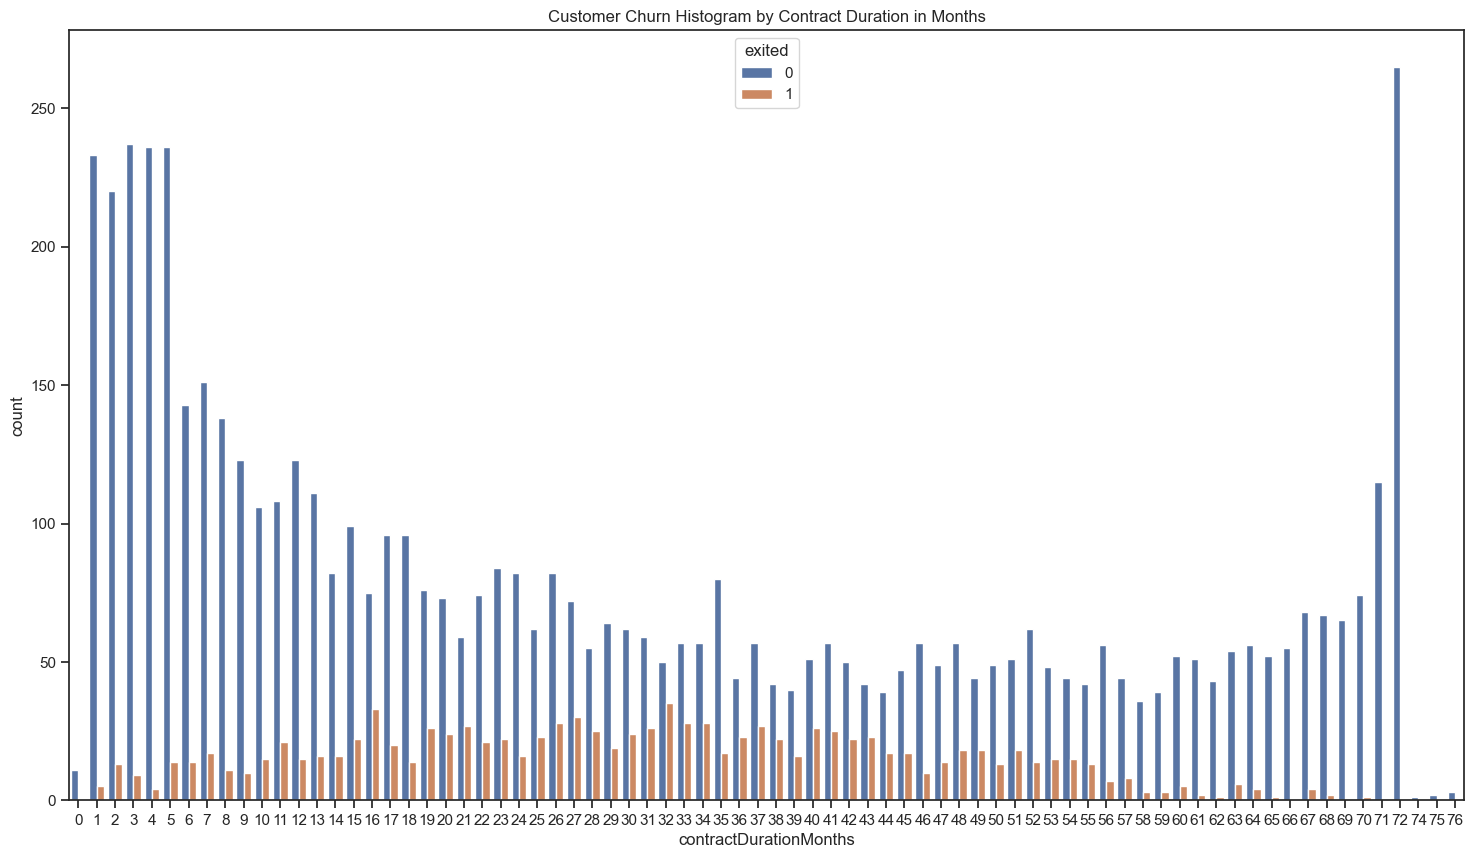

In [66]:
plt.figure(figsize=(18,10))
plt.title('Customer Churn Histogram by Contract Duration in Months')
sns.countplot(
    x=round(df['contractDurationMonths']).astype('int'), 
    hue=df['exited']
)
plt.show()

In [67]:
df[df['exited']==1]['contractDurationMonths'].describe()

count    1101.000000
mean       30.386307
std        15.072883
min         0.919937
25%        18.957268
50%        30.062220
75%        41.035751
max        69.948051
Name: contractDurationMonths, dtype: float64

On average, users terminate their contract in the 30th month of service.  
The shorter the duration of the contract, the less likely the customer is to churn. Additionally, after 30 months, the number of customers who terminated their contracts gradually decreases.  
It is difficult to interpret such a distribution of customer churn, except to assume that we have unusual synthetic data at our disposal.

### Analysis of Categorical Features

In [68]:
cats = ['type', 'paperlessBilling', 'paymentMethod', 'gender', 'seniorCitizen', 'partner', 'dependents', 'internetService', 'onlineSecurity', 'onlineBackup', 'deviceProtection', 'techSupport', 'streamingTV', 'streamingMovies', 'multipleLines']

TYPE


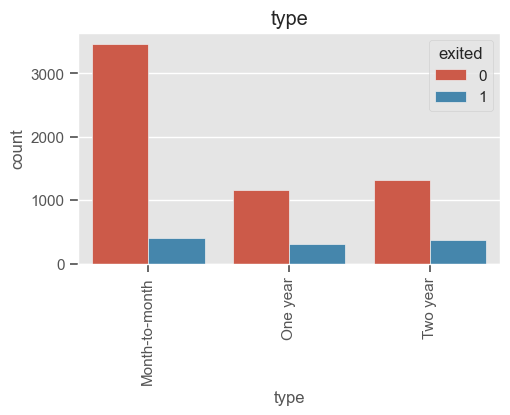

,Not Exited,Exited
type,,
Month-to-month,89.50,10.50
One year,78.75,21.25
Two year,77.52,22.48


PAPERLESSBILLING


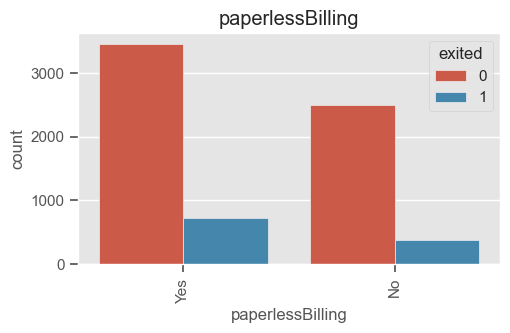

,Not Exited,Exited
paperlessBilling,,
No,86.77,13.23
Yes,82.71,17.29


PAYMENTMETHOD


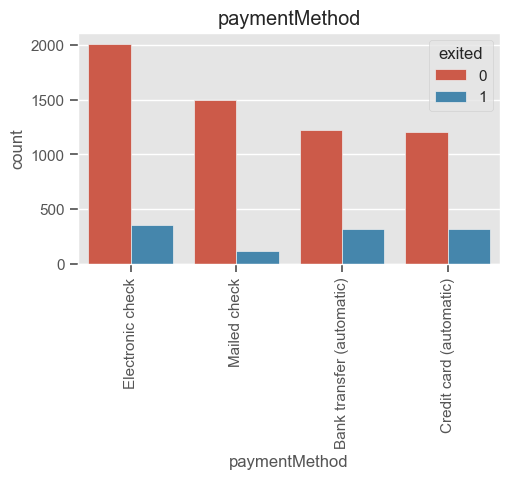

,Not Exited,Exited
paymentMethod,,
Bank transfer (automatic),79.47,20.53
Credit card (automatic),79.17,20.83
Electronic check,85.20,14.80
Mailed check,92.74,7.26


GENDER


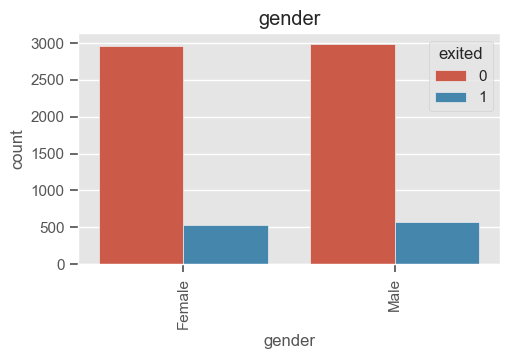

,Not Exited,Exited
gender,,
Female,84.86,15.14
Male,83.88,16.12


SENIORCITIZEN


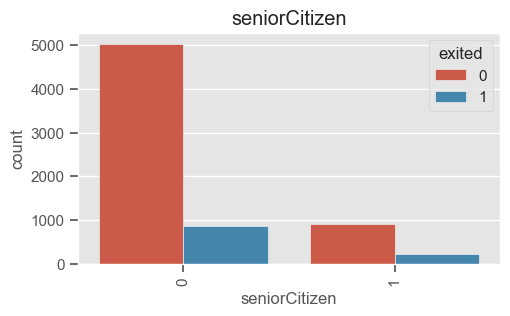

,Not Exited,Exited
seniorCitizen,,
0,85.27,14.73
1,79.68,20.32


PARTNER


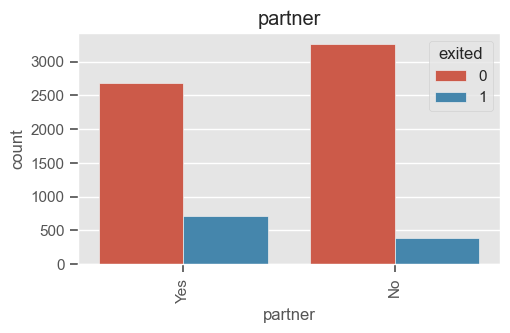

,Not Exited,Exited
partner,,
No,89.51,10.49
Yes,78.87,21.13


DEPENDENTS


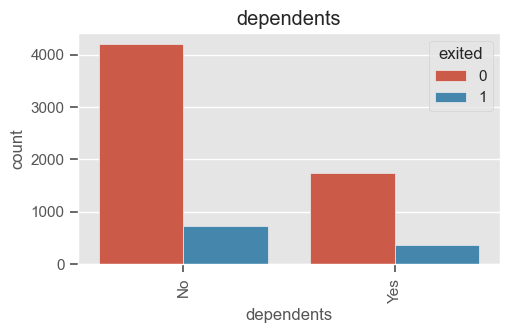

,Not Exited,Exited
dependents,,
No,85.14,14.86
Yes,82.56,17.44


INTERNETSERVICE


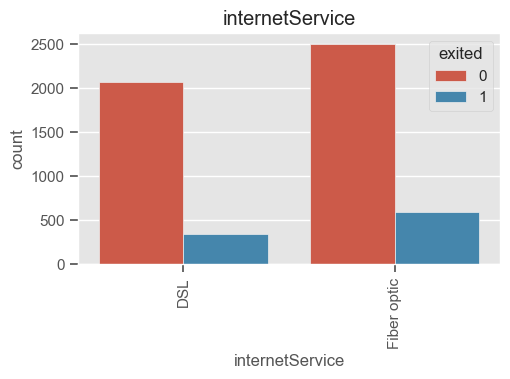

,Not Exited,Exited
internetService,,
DSL,85.71,14.29
Fiber optic,80.78,19.22


ONLINESECURITY


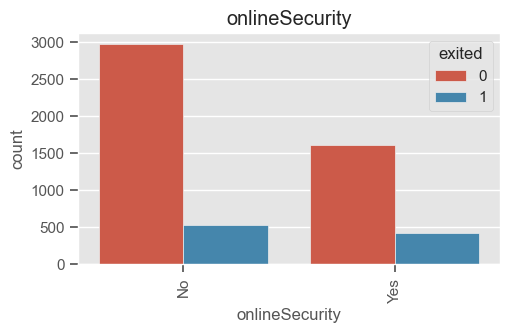

,Not Exited,Exited
onlineSecurity,,
No,84.96,15.04
Yes,79.45,20.55


ONLINEBACKUP


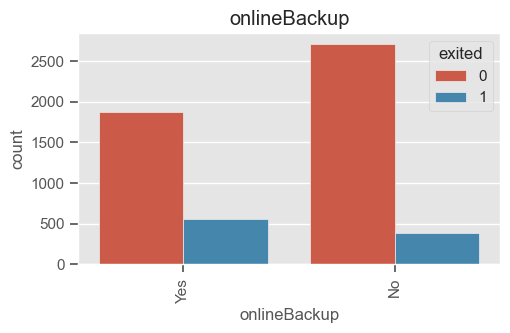

,Not Exited,Exited
onlineBackup,,
No,87.66,12.34
Yes,76.95,23.05


DEVICEPROTECTION


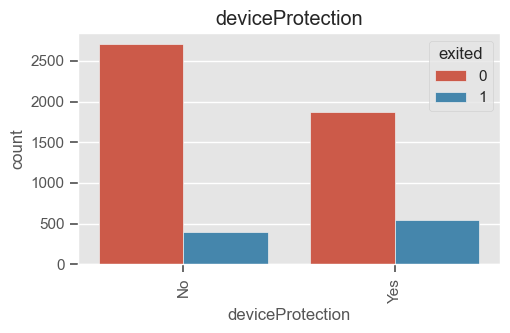

,Not Exited,Exited
deviceProtection,,
No,87.37,12.63
Yes,77.29,22.71


TECHSUPPORT


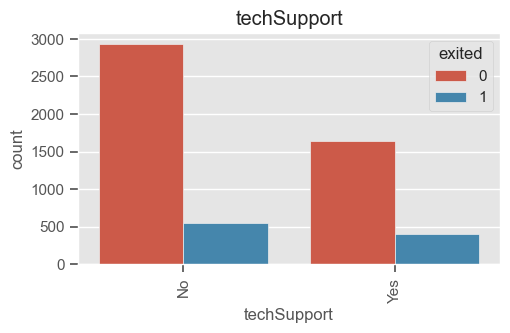

,Not Exited,Exited
techSupport,,
No,84.37,15.63
Yes,80.53,19.47


STREAMINGTV


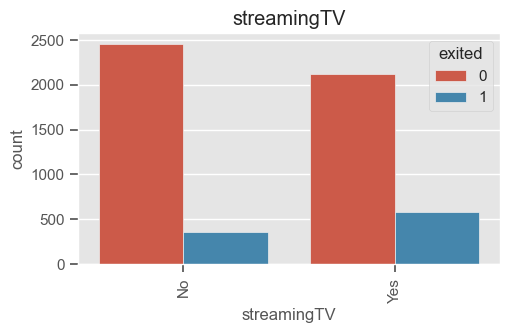

,Not Exited,Exited
streamingTV,,
No,87.30,12.70
Yes,78.43,21.57


STREAMINGMOVIES


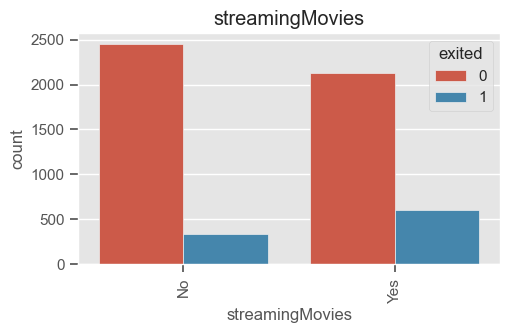

,Not Exited,Exited
streamingMovies,,
No,87.97,12.03
Yes,77.82,22.18


MULTIPLELINES


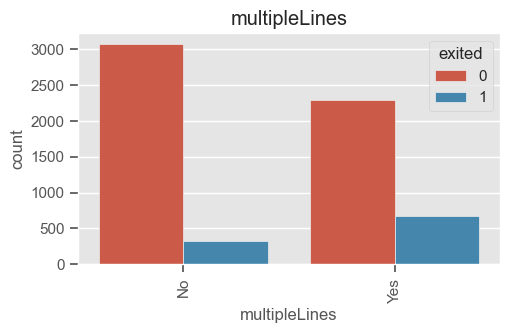

,Not Exited,Exited
multipleLines,,
No,90.56,9.44
Yes,77.18,22.82


In [69]:
plt.style.use("ggplot")
for column in cats:
    print(column.upper())
    plt.figure(figsize=(12,3))
    plt.subplot(121)
    sns.countplot(x=df[column], hue=df["exited"])
    plt.title(column)    
    plt.xticks(rotation=90)
    plt.show()
    pivot_table = pd.crosstab(df[column], df['exited'], normalize='index')
    pivot_table.columns = ['Not Exited', 'Exited']
    pivot_table = round(pivot_table * 100, 2)
    display(pivot_table)

**`type` - subscription type**  
The proportion of contract terminations is twice as high among those with a payment period of 1-2 years.  
  
**`paperlessBilling`**  
Among those who receive electronic bills, the proportion of terminations is higher (13.23% compared to 17.29%).  
  
**`paymentMethod`**  
Customer churn significantly differs depending on the payment method. The lowest proportion of contract terminations is among those who receive bills by mail (7.26%), while it is twice as high (14.8%) among those who receive electronic bills. The highest churn rate is among those who have automatic payment set up with bank transfer and credit card (20.53% and 20.83% respectively).  

**`gender`**  
The proportion of contract terminations is nearly the same for both genders.  
  
**`seniorCitizen`**  
Senior citizens are 33% more likely to terminate their contracts than non-senior citizens, which may be due to natural reasons. Meanwhile, the proportion of senior citizens is approximately five times lower.  
  
**`partner`**
Customers without partners are twice as likely to terminate their contracts compared to customers with partners.  
  
**`dependents`**  
However, the absence of dependents hardly increases the likelihood of contract termination, with a difference of approximately 3%.  
  
**`internetService`**  
Fiber optic users are more likely to terminate their contracts compared to DSL users, with rates of 19.22% and 14.29% respectively.  
  
As for additional services: `onlineSecurity`, `onlineBackup`, `deviceProtection`, `techSupport`, `stramingTV`, `stramingMovies`, `multipleLines`. In all cases, having the service increases the probability of contract termination by 25% to 100% compared to those without the service.

Check for multicollinearity between features.

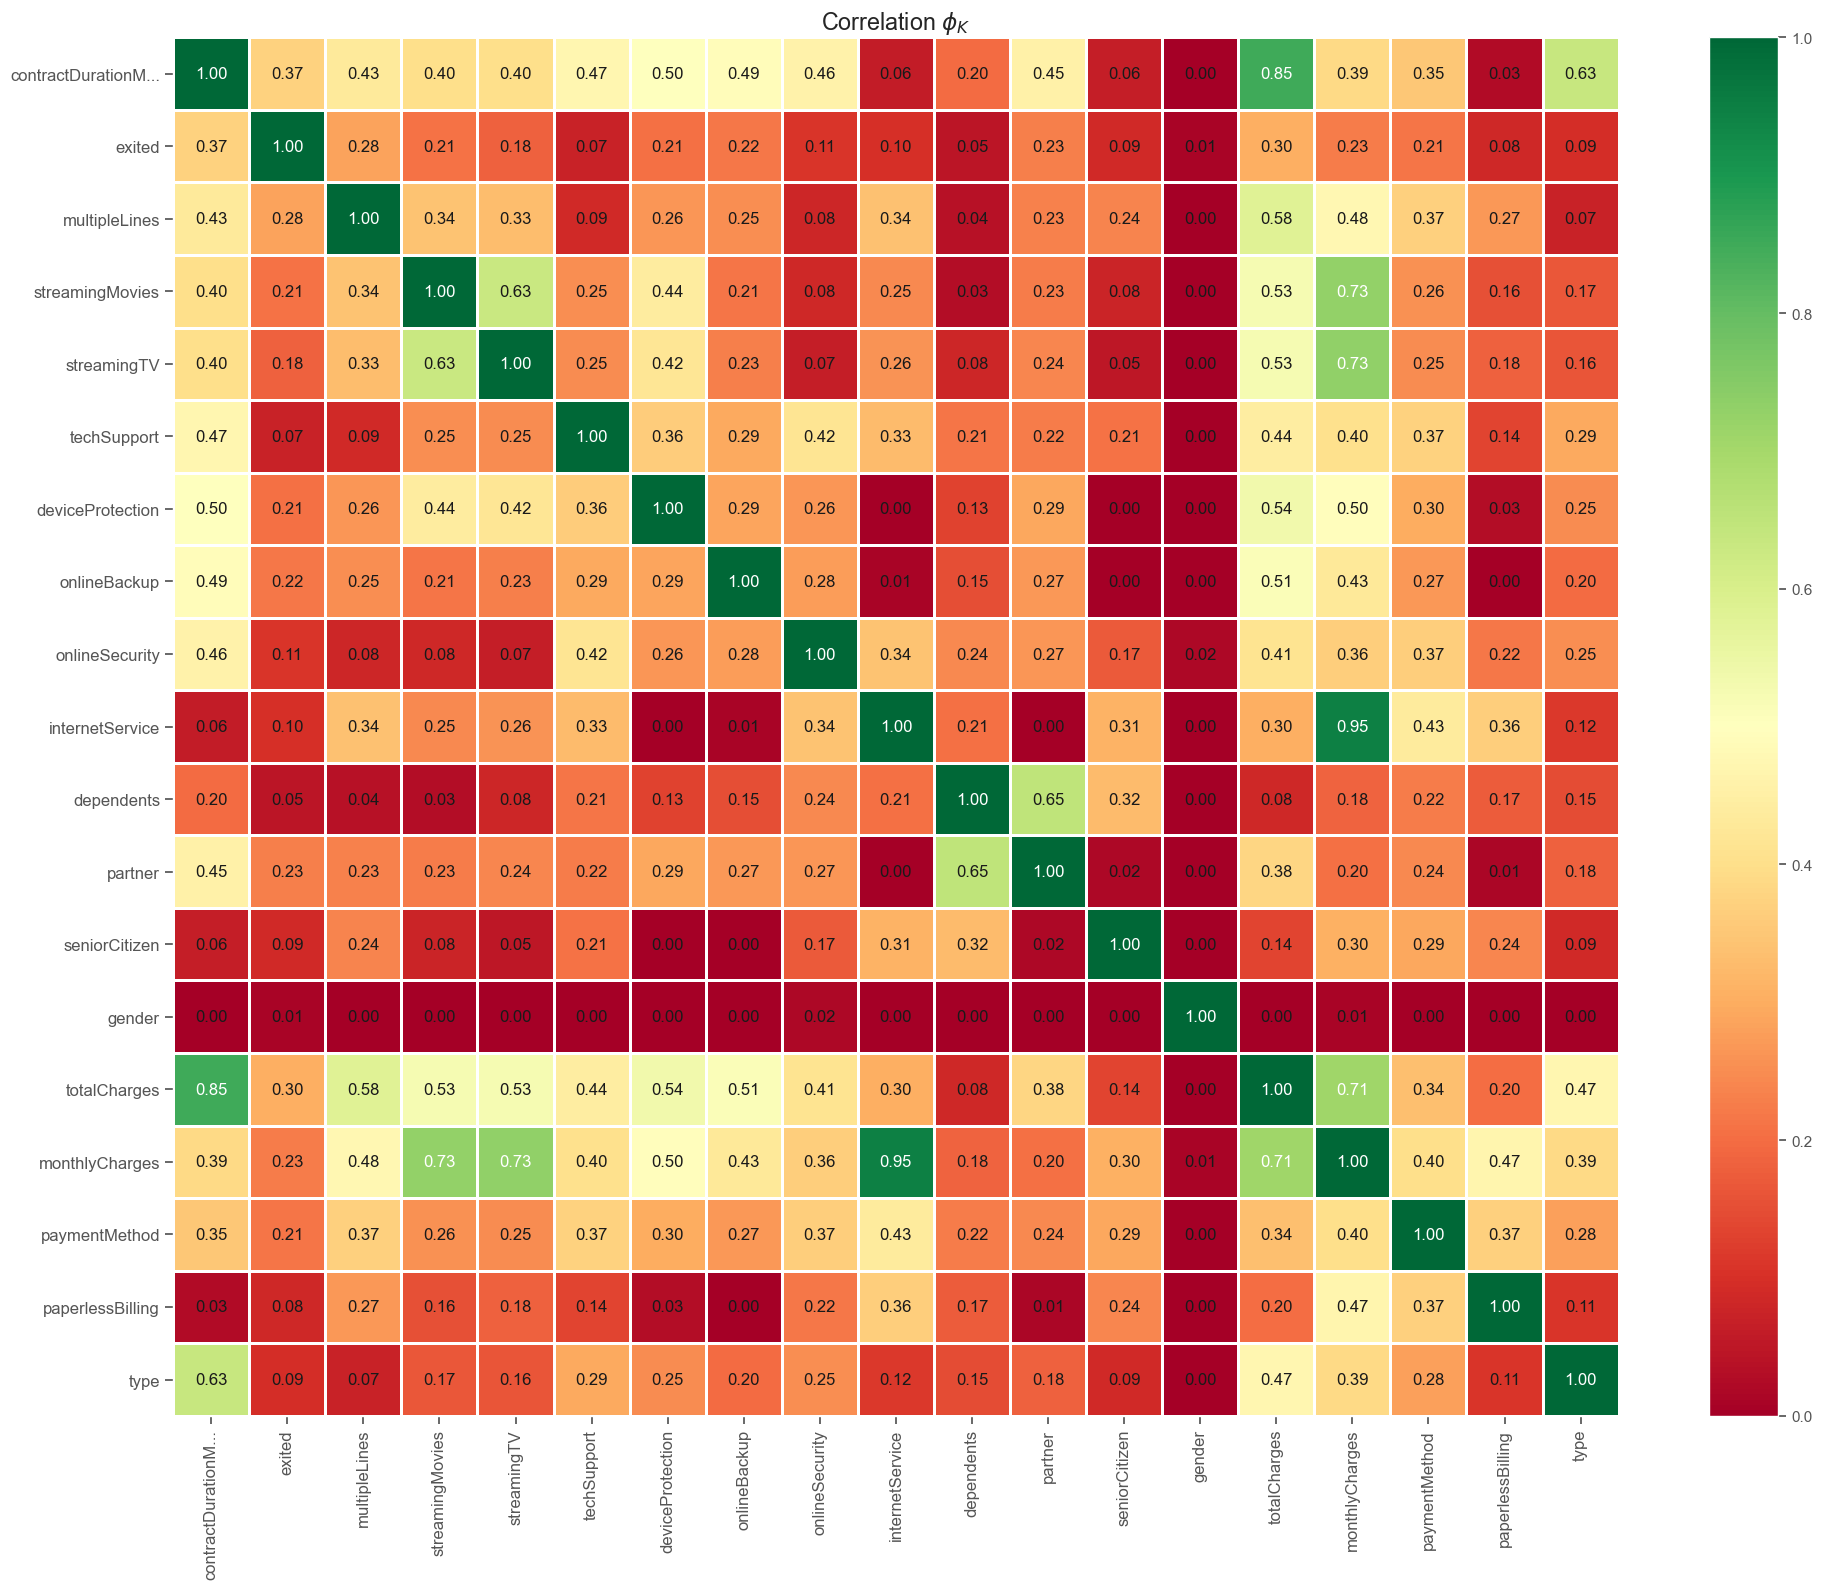

In [70]:
interval_cols = ['monthlyCharges', 'totalCharges', 'seniorCitizen', 'exited', 'contractDurationMonths']
phik_overview = df.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, 
                        vmax=1, 
                        title=r"Correlation $\phi_K$", 
                        fontsize_factor=1.2, 
                        figsize=(20, 16))
plt.tight_layout()
plt.show()

There is multicollinearity among several features, but since we will be using only one linear model, `Logistic Regression`, we can use L2 regularization to address the multicollinearity issue. We will leave the data as is.

Before moving on to the next step, let's extract the target feature from the dataset and separate the test set.

In [38]:
target = df['exited']
features = df.drop('exited', axis=1)
features_train, features_test, target_train, target_test = \
    train_test_split(
        features, 
        target, 
        test_size=0.25, 
        random_state=RANDOM_STATE
    )

## Conclusion

**Based on the analysis, we can create a profile of typical users who either churned or did not churn:**  
- Customers who pay for services on a 1-2 year basis, have fiber optic connection, use automatic payment, have been with the company for 30 months, and have subscribed to additional services are more likely to churn;  
- Customers who are new to the company or have been using its services from the beginning, do not subscribe to additional services, pay bills monthly, and receive paper invoices are more likely to stay.  

# Model Training

We haven't completed all the planned data preprocessing steps, some of which will be performed in the pipeline, including scaling the numerical features, encoding the categorical features, and balancing the classes of the target feature.

## Logistic Regression

Define a list of numerical features for scaling.

In [39]:
num_features = list(set(features.columns) - set(cats))
num_features

['totalCharges', 'monthlyCharges', 'contractDurationMonths']

In [40]:
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), num_features),
    ('ohe', OneHotEncoder(
        handle_unknown='ignore',
        drop='first',
        sparse=False, 
        dtype='int8'
    ), cats),
])

pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('regressor', LogisticRegression(random_state=RANDOM_STATE))
])

params = {
    'regressor__C' : [10, 1, 0.2, 0.1, 0.05, 0.01, 0.001, 0.0001],
    'regressor__penalty':['l2'], 
    'regressor__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
}

grid_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc',
)

grid_lr.fit(features_train, target_train)

print(f'ROC-AUC {grid_lr.best_score_}')
print(f'Best params {grid_lr.best_params_ }')

ROC-AUC 0.7555076921302237
Best params {'regressor__C': 0.1, 'regressor__penalty': 'l2', 'regressor__solver': 'newton-cg'}


## RandomForest

In [41]:
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), num_features),
    ('ohe', OneHotEncoder(
        handle_unknown='ignore',
        drop='first',
        sparse=False, 
        dtype='int8'
    ), cats),
])

pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('regressor', RandomForestClassifier(random_state=RANDOM_STATE))
])

params = {
        'regressor__max_depth': range(1,20,1),
        'regressor__n_estimators': range(1,200,10),
}

grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc',
)

grid_rf.fit(features_train, target_train)

print(f'ROC-AUC {grid_rf.best_score_}')
print(f'Best params {grid_rf.best_params_ }')

ROC-AUC 0.8084353662816068
Best params {'regressor__max_depth': 8, 'regressor__n_estimators': 171}


## Catboost

In [42]:
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), num_features),
    ('ohe', OneHotEncoder(
        handle_unknown='ignore',
        drop='first',
        sparse=False, 
        dtype='int8'
    ), cats),
])

pipe_cb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(
        verbose=500, 
        random_state=RANDOM_STATE, 
    ))
])

params = {
    'classifier__learning_rate': [0.1],
    'classifier__loss_function': ['Logloss'],
    'classifier__eval_metric' : ['AUC'],
    'classifier__depth': [3],
    'classifier__l2_leaf_reg': [0.15],
    'classifier__bagging_temperature': [0.3],
    'classifier__random_strength': [0.1],
    'classifier__scale_pos_weight' : [6],
    'classifier__iterations' : [2000],
    'classifier__min_data_in_leaf': [15],
    'classifier__grow_policy' : ['SymmetricTree'],
    'classifier__od_wait': [20]
}

grid_cb = GridSearchCV(
    pipe_cb, 
    params, 
    cv=4, 
    n_jobs=-1,
    scoring='roc_auc'
)   

grid_cb.fit(features_train, target_train)

print(f'ROC-AUC {grid_cb.best_score_}')
print(f'Best params {grid_cb.best_params_ }')

0:	total: 142ms	remaining: 4m 43s
500:	total: 1.49s	remaining: 4.45s
1000:	total: 2.9s	remaining: 2.89s
1500:	total: 4.43s	remaining: 1.47s
1999:	total: 5.95s	remaining: 0us
ROC-AUC 0.9022772795271583
Best params {'classifier__bagging_temperature': 0.3, 'classifier__depth': 3, 'classifier__eval_metric': 'AUC', 'classifier__grow_policy': 'SymmetricTree', 'classifier__iterations': 2000, 'classifier__l2_leaf_reg': 0.15, 'classifier__learning_rate': 0.1, 'classifier__loss_function': 'Logloss', 'classifier__min_data_in_leaf': 15, 'classifier__od_wait': 20, 'classifier__random_strength': 0.1, 'classifier__scale_pos_weight': 6}


The best model is `CatBoostClassifier` with the following parameters:  
`bagging_temperature` = 0.3  
`depth` = 3  
`eval_metric` = 'AUC'  
`grow_policy` = 'SymmetricTree'   
`iterations` = 2000   
`l2_leaf_reg` = 0.15   
`learning_rate` = 0.1   
`loss_function` = 'Logloss'   
`min_data_in_leaf` = 15   
`od_wait` = 20  
`random_strength` = 0.1  
`scale_pos_weight` = 6  

## Model Testing

Test the best model on the test set.  
First, we need to preprocess the test dataset.

In [43]:
preprocessor.fit(features_train)
features_test_transformed = preprocessor.transform(features_test)
model = grid_cb.best_estimator_
target_predicted = model.predict_proba(features_test)[:,1]
roc_auc = roc_auc_score(target_test, target_predicted)
print(f"ROC-AUC = {roc_auc}")

ROC-AUC = 0.9380725464156446


The result on the test set meets the condition `ROC-AUC >= 0.85`. The test is passed.

Find the threshold for classification.  
Take a look at the ROC curve.

In [44]:
model.predict_proba(features_test)

array([[0.99696321, 0.00303679],
       [0.96800831, 0.03199169],
       [0.20610819, 0.79389181],
       ...,
       [0.98639366, 0.01360634],
       [0.989308  , 0.010692  ],
       [0.58564119, 0.41435881]])

<Figure size 500x500 with 0 Axes>

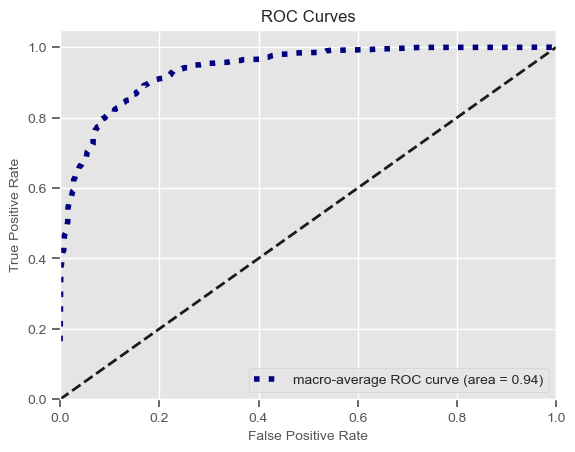

In [45]:
plt.figure(figsize=(5,5))
plot_roc_curve(target_test, model.predict_proba(features_test), curves='macro')
plt.show();

Find the optimal threshold value.

In [46]:
target_predicted_probabilities = model.predict_proba(features_test)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, target_predicted_probabilities)

# Determining index of a point on a plot, nearest to the top left corner
index = np.argmax(np.abs(tpr - fpr))

# Determining a threshold corresponding to this point
threshold = thresholds[index]

print("Optimal threshold value:", threshold)

Optimal threshold value: 0.37966854317300214


Evaluate the `accuracy` at the optimal threshold value.

In [47]:
target_predicted = model.predict_proba(features_test)[:, 1] > threshold
accuracy = accuracy_score(target_test, target_predicted)
print(f"Accuracy with optimal threshold = {accuracy:.2f}")

Accuracy with optimal threshold = 0.90


The model is capable of predicting customer churn in 89% of cases, allowing the company to attempt to retain them by offering promotional codes and special conditions.

## Sanity Check

In [48]:
model_dm = DummyClassifier(strategy='uniform')

model_dm.fit(features_train, target_train)
target_predicted = model.predict(features_test)

roc_auc = roc_auc_score(target_test, target_predicted)
accuracy = model_dm.score(target_test, target_predicted)

print(f"ROC-AUC: {roc_auc}")
print(f"Accuracy: {accuracy}")

ROC-AUC: 0.8606163580970236
Accuracy: 0.49176604202157864


The `DummyClassifier` predictably showed lower results than each of the trained models, passing the adequacy test.

# Conclusion

In the initial stage, the raw data was analyzed. Based on the analysis, new features were created and some features were removed. The data was prepared for machine learning models.  
  
During the training stage, three different models were trained. The `CatBoostClassifier` model performed the best with an `accuracy` score of 0.9 on the test set. This means that the model is capable of predicting 90% of customers who are likely to churn. The forecast will enable the company to take necessary measures to retain customer loyalty.

# Solution Report

During the project, the set tasks were solved, and the necessary indicators were achieved.  

 **During the data preprocessing and analysis stage, the following steps were performed:**  
 - The data contained in the original `csv` files were studied; when there was insufficient information about the features, data interpretation was proposed;  
 - Data from different tables were collected into one dataframe;  
 - Column headers were standardized to camelCase;  
 - New features were generated, including the target feature, which was initially represented implicitly;   
 - Data types were downcasted using the `downcast` method;  
 - Unnecessary features were removed;    
 - Each feature was analyzed in relation to the target feature classes, revealing correlations between features and customer churn;  
 - Multicollinearity analysis was conducted using the `phik` package;  
 - The dataset was divided into a training set and a test set in a `3:1` ratio;
 - Based on the analysis, a profile of typical users who churned or did not churn from the services was proposed.  
   
**During the model training stage, the following tasks were performed:**  
- The following features were used for training: 'type', 'paperlessBilling', 'paymentMethod', 'monthlyCharges', 'totalCharges', 'gender', 'seniorCitizen', 'partner', 'dependents',
'internetService', 'onlineSecurity', 'onlineBackup', 'deviceProtection', 'techSupport', 'streamingTV', 'streamingMovies', 'multipleLines', 'contractDurationMonths'.
- Three models were trained: `LogisticRegression`, `RandomForest`, `CatBoostClassifier`;  
- Hyperparameters were tuned for each model using `GridSearchCV`;  
- Since cross-validation was used, a pipeline was created, including the following preprocessing steps:
    - Scaling of numerical features using `StandardScaler`;
    - Encoding of categorical features using `OneHotEncoder`;
    - Balancing of the dataset using `SMOTE` (except for the `CatBoost` model).
- The value `220523` was chosen for the `random_state` argument in all methods and functions that have it;
- The target metric `roc-auc` was selected as the loss function;
- The best model is the `CatBoostClassifier` with the following parameters:   
    - `bagging_temperature` = 0.3  
    - `depth` = 3  
    - `eval_metric` = 'AUC'  
    - `grow_policy` = 'SymmetricTree'   
    - `iterations` = 2000   
    - `l2_leaf_reg` = 0.15   
    - `learning_rate` = 0.1   
    - `loss_function` = 'Logloss'   
    - `min_data_in_leaf` = 15   
    - `od_wait` = 20  
    - `random_strength` = 0.1  
    - `scale_pos_weight` = 6  
- The model achieved a result of `ROC-AUC = 0.90` on the training data;  
- The model was tested on the test set with preprocessing through the `preprocessor`. It achieved a result of `ROC-AUC = 0.94` on the test set, satisfying the task requirement of `ROC-AUC >= 0.85`;  
- An ROC curve was plotted, and the optimal threshold was determined as `0.35`;  
- At the optimal threshold, the accuracy is `0.89`;  
- In the final stage, the model was compared to a constant model and passed the adequacy test.  
  
Based on the results, conclusions were drawn, and an explanation of the findings was provided in business terms.  